<a href="https://colab.research.google.com/github/Aditi1203/CMPE-295/blob/master/Triple_Loss_MIT_Compare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Aditi1203/CMPE-295.git

Cloning into 'CMPE-295'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 1114395 (delta 1), reused 5 (delta 0), pack-reused 1114385
Receiving objects: 100% (1114395/1114395), 3.02 GiB | 29.31 MiB/s, done.
Resolving deltas: 100% (220392/220392), done.
Checking out files: 100% (778066/778066), done.


In [1]:
cd CMPE-295/anand_sandbox/

/content/CMPE-295/anand_sandbox


In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import imutils
import random
from keras.applications import VGG19, VGG16
from keras.applications.vgg19 import preprocess_input
from keras.applications.vgg16 import preprocess_input
from itertools import permutations
from keras.optimizers import SGD,Adam
from PIL import Image
import keras
from keras import backend as K
from keras import Sequential, losses, optimizers, Input, optimizers
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Lambda, Dense, Conv2D, MaxPool2D, MaxPooling2D, concatenate, Average, Flatten, Dropout, Activation
from keras.utils import to_categorical, plot_model,vis_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard, EarlyStopping
from keras.preprocessing.image import img_to_array
from skimage import io
import imutils
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pywt
from scipy import signal

Using TensorFlow backend.


In [0]:
def load_data(number_of_items=3):
    """
        number_of_items -> Number of items to return
        returns the data in a dictionary of images and labels.
    """
    path = "scalogram_module/Scalogram"
    path1= "scalogram_module/Scalogram/Cropped"
    data = [] 
    curated_data = {"label":[], "scalogram":[]}
    for subject_name in os.listdir(path)[:number_of_items]:
        if subject_name == ".DS_Store":
            number_of_items=number_of_items+1
            continue
        if subject_name  ==".ipynb_checkpoints":
            number_of_items=number_of_items+1
            continue
        print ("Going through subject:" + subject_name)
        base=os.path.basename(path+"/"+subject_name)
        labelData=os.path.splitext(base)[0]
        print(labelData)
        i=0
        for items in os.listdir(path+"/"+subject_name):
            if items == ".DS_Store":
                continue
            if items.endswith(".png"):
                try:
                    im2 = cv2.imread(path+"/"+subject_name+"/"+items)
                    crop_img = im2[30:20+235, 50:50+342]
                    im = cv2.resize(crop_img, (224,224)) # Changing into 80x80X3
                    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
                    curated_data['scalogram'].append(im)
                    curated_data['label'].append(labelData)
                except:
                      df = None  

    return curated_data

In [4]:
data = load_data(number_of_items=6)

Going through subject:person_103
person_103
Going through subject:person_214
person_214
Going through subject:person_213
person_213
Going through subject:person_228
person_228
Going through subject:person_101
person_101


In [5]:
print(data['scalogram'][0].shape)
print(len(data['scalogram']))

(224, 224)
5394


In [6]:
len(data['label'])

5394

In [7]:
data_array=np.array(data['scalogram'])
labels=np.array(data['label'])
print("Data shape:{}".format(data_array.shape))
print("Labels shape:{}".format(labels.shape))

Data shape:(5394, 224, 224)
Labels shape:(5394,)


In [0]:
data_array = data_array / 255.0

In [9]:
encoder = LabelEncoder()
encoder.fit(labels)
labels = encoder.transform(labels)
print("Encoded Labels shape:{} value:{}".format(labels.shape,labels))

Encoded Labels shape:(5394,) value:[1 1 1 ... 0 0 0]


In [10]:
x_train, x_test, y_train,  y_test=train_test_split(data_array, labels, test_size=0.2, random_state=2)
print("Shapes:")
print("Train Data:{}".format(x_train.shape))
print("Train Label:{}".format(y_train.shape))
print("Test Data:{}".format(x_test.shape))
print("Test Label:{}".format(y_test.shape))

Shapes:
Train Data:(4315, 224, 224)
Train Label:(4315,)
Test Data:(1079, 224, 224)
Test Label:(1079,)


In [11]:
x_train_master = np.expand_dims(x_train, 3)
x_test_master = np.expand_dims(x_test, 3)
print(x_train.shape, x_test.shape)

(4315, 224, 224) (1079, 224, 224)


In [12]:
y_train_master = y_train.flatten()
y_test_master = y_test.flatten()
print(y_train_master.shape,y_test_master.shape)

(4315,) (1079,)


In [13]:
shape=x_train.shape
dim_x = shape[1]
dim_y = shape[2]
print("Dimension of Scalogram Image: {}*{}".format(dim_x,dim_y ))

Dimension of Scalogram Image: 224*224


In [0]:
num_train_per_class = 1
n_epochs = 10

In [0]:
def generate_triplets(dataset, label, sample_per_class=20):
    x, y = None, None
    for i in set(label):
        pos_indices = np.argwhere(label == i)[:,0]
        print(len(pos_indices))
        neg_indices = np.argwhere(label != i)[:,0]

        # print("pos indices: {}, neg_indices: {}".format(pos_indices.shape, neg_indices.shape))
        choice_anchor = np.random.choice(pos_indices.shape[0], sample_per_class, replace=True)
        choice_anchor = pos_indices[choice_anchor]

        choice_pos = np.random.choice(pos_indices.shape[0], sample_per_class, replace=True)
        choice_pos = pos_indices[choice_pos]

        choice_neg = np.random.choice(neg_indices.shape[0], sample_per_class, replace=True)
        choice_neg = neg_indices[choice_neg]

        sub_x_anc = dataset[choice_anchor]

        sub_x_pos = dataset[choice_pos]

        sub_x_neg = dataset[choice_neg]


        if(x is None):
            x = [(sub_x_anc), (sub_x_pos), (sub_x_neg)]
            y = [label[choice_anchor], label[choice_pos], label[choice_neg]]
        else:
            x[0] = np.vstack((x[0], (sub_x_anc)))
            x[1] = np.vstack((x[1], (sub_x_pos)))
            x[2] = np.vstack((x[2], (sub_x_neg)))

            y[0] = np.hstack((y[0].flatten(), label[choice_anchor].flatten()))
            y[1] = np.hstack((y[1].flatten(), label[choice_pos].flatten()))
            y[2] = np.hstack((y[2].flatten(), label[choice_neg].flatten()))
            # y[0] = np.vstack((y[0].flatten(), label[choice_anchor].flatten()))
            # y[1] = np.vstack((y[1].flatten(), label[choice_pos].flatten()))
            # y[2] = np.vstack((y[2].flatten(), label[choice_neg].flatten()))

    return x, y

In [0]:
# def generate_triplets(dataset, label, sample_per_class=10):
#     x, y = None, None
#     for i in set(label):
#         print("Label: ",i)
#         pos_indices = np.argwhere(label == i)[:,0]
#         print("Length of positive indices: ",len(pos_indices))
#         #print("Positive indices: ",pos_indices)
#         neg_indices = np.argwhere(label != i)[:,0]
#         print("Length of negative indices",len(neg_indices))
#         #print("Negative indices: ",neg_indices)
#         print()

#         #print("Pos_indices.shape[0]: ", pos_indices.shape[0])
#         #pos_indices.shape[0] = Total number of positive indices for the label
#         choice_anchor = np.random.choice(pos_indices.shape[0], sample_per_class, replace=True)
#         choice_anchor = pos_indices[choice_anchor]
#         #print("choice anchor: ",choice_anchor)

#         choice_pos = np.random.choice(pos_indices.shape[0], sample_per_class, replace=True)
#         choice_pos = pos_indices[choice_pos]

#         choice_neg = np.random.choice(neg_indices.shape[0], sample_per_class, replace=True)
#         choice_neg = neg_indices[choice_neg]

#         #dataset=features_train[choice anchor] : For all the indices selected for the positive move, add the training data to subject's anchor dataset
#         #Ek label ki sarri images stored index wise eg: all images for label 1 will be stored in sub_x_anc[1]
#         sub_x_anc = dataset[choice_anchor]
#         #print("sub_x_anc: ",sub_x_anc)
#         sub_x_pos = dataset[choice_pos]

#         sub_x_neg = dataset[choice_neg]


#         if(x is None):
#             #x in the subject wise image triplet
#             #y is the label triplet
#             x = [(sub_x_anc), (sub_x_pos), (sub_x_neg)]
#             y = [label[choice_anchor], label[choice_pos], label[choice_neg]]
#             #print("Triplet Label for subject: ",i," ",len(y))
#             #print("Triplet Image for subject: ",i," ",len(x))
#         else:
#             x[0] = np.vstack((x[0], (sub_x_anc)))
#             x[1] = np.vstack((x[1], (sub_x_pos)))
#             x[2] = np.vstack((x[2], (sub_x_neg)))

#             y[0] = np.hstack((y[0].flatten(), label[choice_anchor].flatten()))
#             y[1] = np.hstack((y[1].flatten(), label[choice_pos].flatten()))
#             y[2] = np.hstack((y[2].flatten(), label[choice_neg].flatten()))
#             #print("Label for subject: ",i," ",len(y))
#             #print("Triplet Image for subject: ",i," ",len(x))

#     return x, y

In [16]:
train_x, train_y = generate_triplets(x_train_master, y_train_master)

708
765
1228
830
784


In [17]:
print(y_train_master)

[4 3 1 ... 2 4 2]


In [18]:
print(len(train_x),train_x[0].shape, len(train_y))
      
print("Anchor labels:{}".format(train_y[0]))
print("Positive labels:{}".format(train_y[1]))
print("Negative labels:{}".format(train_y[2]))

3 (100, 224, 224, 1) 3
Anchor labels:[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Positive labels:[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Negative labels:[2 3 2 1 1 2 3 3 1 1 1 1 2 2 2 2 3 1 2 3 2 0 2 0 2 3 2 0 2 0 0 4 2 2 3 3 2
 2 3 2 4 4 0 1 3 1 0 4 1 3 3 4 3 3 4 3 0 0 1 3 1 2 4 2 2 2 2 1 1 1 2 1 2 2
 2 4 4 1 1 2 2 1 2 0 1 1 3 2 2 0 3 0 3 2 0 2 1 2 0 2]


In [0]:
def visualize_data(data, n):
    n = min(len(data[0]), n)
    random_choices = np.random.choice(len(data[0]),n, replace=False)
    fig, ax = plt.subplots(n, 3,figsize=(10,40))
    anc, pos, neg = data
    for i,ch in enumerate(random_choices):
        ax[i, 0].imshow(np.squeeze(anc[ch] ))
        ax[i, 1].imshow(np.squeeze(pos[ch] ))
        ax[i, 2].imshow(np.squeeze(neg[ch] ))


        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
        ax[i, 2].set_axis_off()

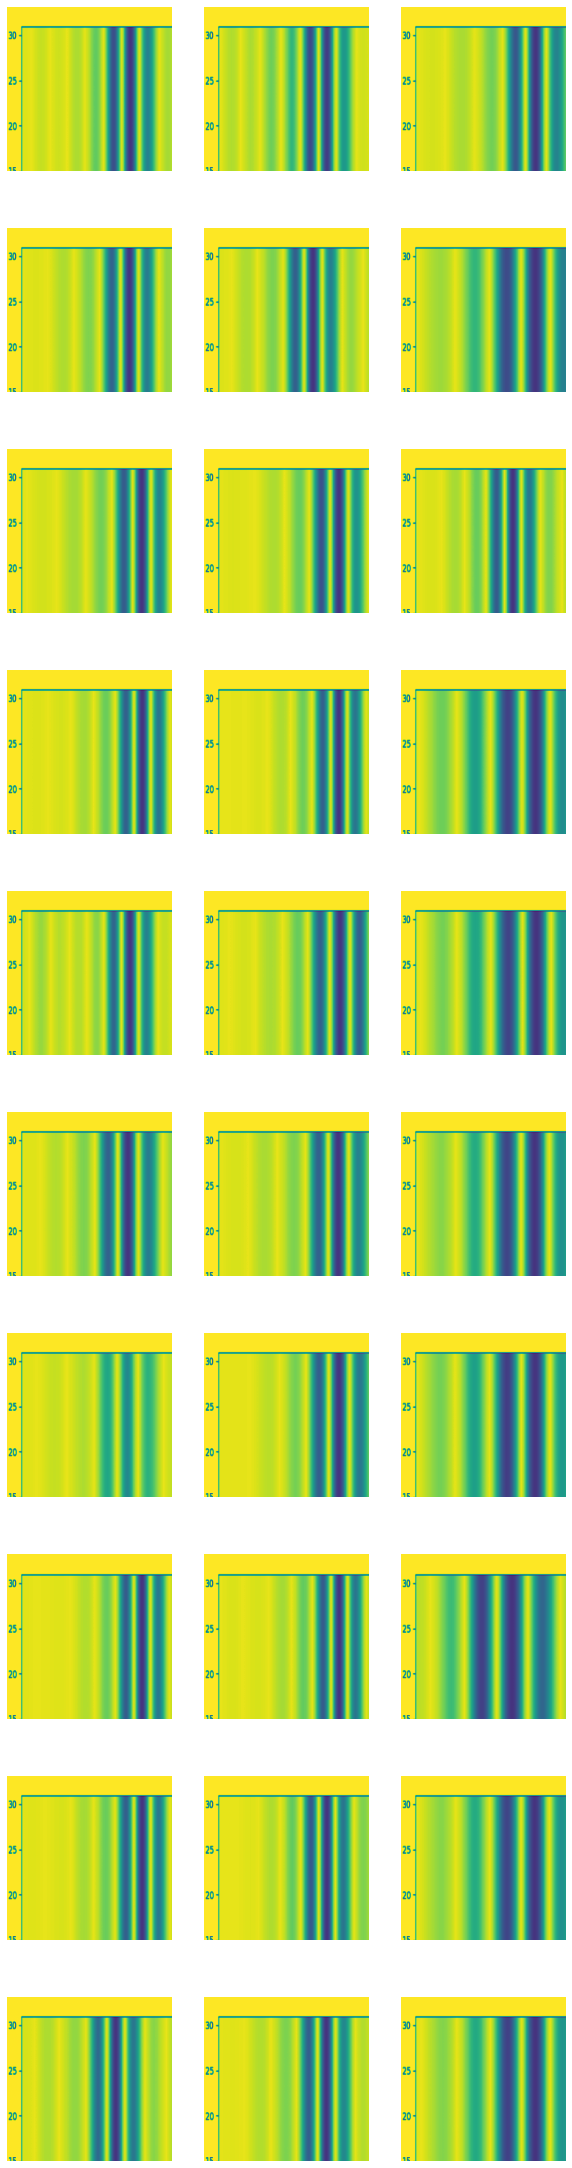

In [20]:
visualize_data(train_x, 10)

In [21]:
num_train_per_class=1000
num_test_per_class=30
train_x, train_y = generate_triplets(x_train_master, y_train_master, num_train_per_class)


708
765
1228
830
784


In [22]:
test_x, test_y = generate_triplets(x_test_master, y_test_master,num_test_per_class)

172
210
294
215
188


In [23]:
print("Length of generated triplet for Train Data:{},{}".format(len(train_x),train_x[0].shape))
print("Length of generated triplet for Test Data:", len(test_x),test_x[0].shape)
print("Length of generated triplet for Train Label:{},{}".format(len(train_y),train_y[0].shape))
print("Length of generated triplet for Test Label:", len(test_y),test_y[0].shape)

Length of generated triplet for Train Data:3,(5000, 224, 224, 1)
Length of generated triplet for Test Data: 3 (150, 224, 224, 1)
Length of generated triplet for Train Label:3,(5000,)
Length of generated triplet for Test Label: 3 (150,)


In [0]:
def triplet_loss(inputs, dist='euclidean', margin='maxplus'):
    print("loss calculation")
    alpha=0.4
    anchor, positive, negative = inputs
    positive_distance = K.square(anchor - positive)
    negative_distance = K.square(anchor - negative)
    if dist == 'euclidean':
        positive_distance = K.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
        negative_distance = K.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
    elif dist == 'sqeuclidean':
        positive_distance = K.sum(positive_distance, axis=-1, keepdims=True)
        negative_distance = K.sum(negative_distance, axis=-1, keepdims=True)
    loss = positive_distance - negative_distance
    if margin == 'maxplus':
        loss = K.maximum(0.0, alpha + loss)
    elif margin == 'softplus':
        loss = K.log(1 + K.exp(loss))
    return K.mean(loss)

In [0]:
def our_model(in_dims):
   model = Sequential()
   model.add(Conv2D(64, kernel_size=5, input_shape=(in_dims[0],in_dims[1],in_dims[2],), activation="relu"))
   model.add(MaxPool2D(pool_size=(2, 2)))
  #  model.add(Dropout(0.25))
   model.add(Conv2D(64, kernel_size=5, activation="relu"))
   model.add(MaxPool2D(pool_size=(2, 2)))
  #  model.add(Conv2D(128, kernel_size=5, activation="relu"))
  #  model.add(MaxPool2D(pool_size=(2, 2)))
   model.add(Dropout(0.25)) 
   return model

In [0]:
from keras.models import load_model

def create_base_network(in_dims, embedding_dim):

    _input = Input(shape=in_dims)
    our_model_object=our_model(in_dims)
    output_ourModel = our_model_object(_input)

    x = Flatten()(output_ourModel)
    x = Dense(embedding_dim * 4,activation="relu")(x)
    x = Dense(embedding_dim * 2, activation='relu')(x)
    x = Dense(embedding_dim)(x)
    
    return Model(_input, x)

In [0]:
def network_model(input_shape, triplet_margin=.3, embedding_dim=50):

  anchor_input = Input((dim_x,dim_y,1, ), name='anchor_input')
  positive_input = Input((dim_x,dim_y,1, ), name='positive_input')
  negative_input = Input((dim_x,dim_y,1, ), name='negative_input')

  Shared_DNN=create_base_network(input_shape, embedding_dim)
  
  encoded_anchor = Shared_DNN(anchor_input)
  encoded_positive = Shared_DNN(positive_input)
  encoded_negative = Shared_DNN(negative_input)

  inputs=[anchor_input, positive_input, negative_input]
  outputs=[encoded_anchor, encoded_positive, encoded_negative]

  triplet=Model(inputs=inputs, outputs=outputs)
  triplet.add_loss((triplet_loss(outputs, dist='euclidean', margin='maxplus'))) 

  return Shared_DNN, triplet



In [28]:
#print(dim_x)
Shared_DNN, triplet= network_model((dim_x,dim_y,1), triplet_margin=.3, embedding_dim=150)

loss calculation


In [29]:
#model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizers.RMSprop(),metrics=['accuracy'])
triplet.compile(loss=None, optimizer=optimizers.RMSprop(lr=0.0001))
triplet.summary()
# Adam(0.0001)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 150)          108195778   anchor_input[0][0]               
                                                                 positive_input[0][0]       

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output model_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_1.
  'be expecting any data to be passed to {0}.'.format(name))


In [30]:
## Training
n_epochs=10
#my_model.fit(features_train, labels_train, epochs=100, batch_size=16, callbacks=[tensorboard,earlystopping], validation_data=(features_test, labels_test))
history = triplet.fit(train_x, shuffle=True, batch_size=32, validation_split=.1, epochs=n_epochs)

Train on 4500 samples, validate on 500 samples
Epoch 1/10
4500/4500 [==============================] - 30s 7ms/step - loss: 0.0874 - val_loss: 0.1559
Epoch 2/10
4500/4500 [==============================] - 24s 5ms/step - loss: 0.0427 - val_loss: 0.1594
Epoch 3/10
4500/4500 [==============================] - 24s 5ms/step - loss: 0.0298 - val_loss: 0.1124
Epoch 4/10
4500/4500 [==============================] - 24s 5ms/step - loss: 0.0272 - val_loss: 0.1093
Epoch 5/10
4500/4500 [==============================] - 24s 5ms/step - loss: 0.0221 - val_loss: 0.0878
Epoch 6/10
4500/4500 [==============================] - 24s 5ms/step - loss: 0.0172 - val_loss: 0.1197
Epoch 7/10
4500/4500 [==============================] - 24s 5ms/step - loss: 0.0170 - val_loss: 0.0899
Epoch 8/10
4500/4500 [==============================] - 24s 5ms/step - loss: 0.0147 - val_loss: 0.0888
Epoch 9/10
4500/4500 [==============================] - 24s 5ms/step - loss: 0.0138 - val_loss: 0.1847
Epoch 10/10
4500/4500 [===

In [0]:
# from matplotlib import pyplot as plt
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right')
# plt.show()

In [42]:
## Training
n_epochs=15
#my_model.fit(features_train, labels_train, epochs=100, batch_size=16, callbacks=[tensorboard,earlystopping], validation_data=(features_test, labels_test))
history = triplet.fit(train_x, shuffle=True, batch_size=32, validation_split=.1, epochs=n_epochs)

Train on 90 samples, validate on 10 samples
Epoch 1/15
90/90 [==============================] - 1s 6ms/step - loss: 0.0628 - val_loss: 0.4744
Epoch 2/15
90/90 [==============================] - 1s 6ms/step - loss: 0.0638 - val_loss: 0.4964
Epoch 3/15
90/90 [==============================] - 1s 6ms/step - loss: 0.0671 - val_loss: 0.4949
Epoch 4/15
90/90 [==============================] - 1s 6ms/step - loss: 0.0543 - val_loss: 0.5853
Epoch 5/15
90/90 [==============================] - 1s 6ms/step - loss: 0.0521 - val_loss: 0.4958
Epoch 6/15
90/90 [==============================] - 1s 6ms/step - loss: 0.0629 - val_loss: 0.4896
Epoch 7/15
90/90 [==============================] - 1s 6ms/step - loss: 0.0539 - val_loss: 0.5771
Epoch 8/15
90/90 [==============================] - 1s 6ms/step - loss: 0.0742 - val_loss: 0.5234
Epoch 9/15
90/90 [==============================] - 1s 6ms/step - loss: 0.0467 - val_loss: 0.5228
Epoch 10/15
90/90 [==============================] - 1s 6ms/step - loss: 0

In [34]:
print(len(train_x), train_x[0].shape)

3 (7500, 224, 224, 1)


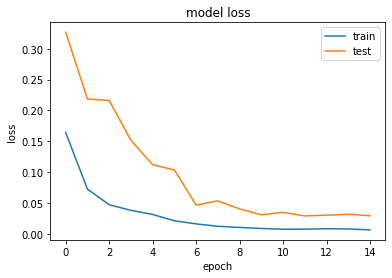

In [35]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [0]:
==============================Case-2=========================

In [0]:
# ## Training
# n_epochs=20
# #my_model.fit(features_train, labels_train, epochs=100, batch_size=16, callbacks=[tensorboard,earlystopping], validation_data=(features_test, labels_test))
# history = triplet.fit(train_x, shuffle=True, batch_size=32, validation_split=.1, epochs=n_epochs)

In [0]:
# Get the embeddings of the images
def get_image_embedding(test_model, input):
  train_data_v_stack=np.vstack((input[0], input[1], input[2]))
  train_embeds = test_model.predict(train_data_v_stack)
  return train_embeds


In [0]:
train_data_v_stack=np.vstack((train_x[0], train_x[1], train_x[2]))
train_embeds = Shared_DNN.predict(train_data_v_stack)
# print(train_data_v_stack.shape)


In [33]:
# train_embeds=get_image_embedding(Shared_DNN, train_x)

print("Train Embeddings shape:{}".format(train_embeds.shape))
print(train_embeds[0], train_embeds[1])

Train Embeddings shape:(15000, 150)
[ 1.3253859   0.6607114  -0.60364133  0.97524095 -1.0446159  -2.655918
  1.2132497  -2.1330109  -1.8383998  -0.33836132  0.99486256  1.7019386
  1.2906231  -1.0643237  -1.8109257   1.4849695  -0.43877628 -0.10240667
  0.6993357  -0.0066659   0.7429271   0.9616509   0.2251841  -1.6972002
 -0.3729576  -2.0318115   1.6058207  -0.38750076  0.31574762  0.7544483
  0.5739843  -2.5856767   1.1409411  -0.34345293 -0.01376814  0.15983112
  0.9056606   0.02847091  0.3884877  -1.0721431   1.6934364  -0.9927038
  0.11645361  0.512742    0.81783134  1.2252449   1.2437171  -0.04812191
  1.9979511   1.6165901   0.34633094 -0.08560491  0.38214234 -0.70408374
  0.23098995  0.40318072 -0.5609559  -1.7770058  -1.4743985  -0.6275107
 -0.13941856  2.115455   -0.68101144 -0.9537798  -1.0207341  -1.2891129
  1.5003619   1.5857236  -1.1207564  -1.9894515   0.33647072 -2.8455787
 -0.18578532 -1.5223182   0.1210601   0.4194057  -2.611651   -0.83553934
  1.3011692  -3.250386  

In [34]:
train_data_v_stack = np.vstack((train_x[0], train_x[1], train_x[2]))
train_label_v_stack = np.vstack((train_y[0], train_y[1], train_y[2]))
print("Shape of vertical_stacked train data: {}".format(train_data_v_stack.shape))
print("Shape of vertical_stacked train label in form of [[],[],[]]: {}".format(train_label_v_stack.shape))
print("Labels of Anchor Image:{}".format(train_label_v_stack[0]))

Shape of vertical_stacked train data: (15000, 224, 224, 1)
Shape of vertical_stacked train label in form of [[],[],[]]: (3, 5000)
Labels of Anchor Image:[0 0 0 ... 4 4 4]


In [92]:
print("What is your claimed identity?")
claimed_label=input()
print(claimed_label)

What is your claimed identity?
3
3


In [0]:
from itertools import chain 
def get_k_template_values(label):
  label=int(label)
  target_label=np.argwhere(train_label_v_stack[0]==label)
  # List of list format.So need to change into single list using chain
  target_label = list(chain.from_iterable(target_label)) 
  print(target_label)

  k_template_value=[]
  for value in target_label:
    k_template_value.append(train_embeds[value])
  print("K templates, Value of k:{}, template shape:{}".format(len(k_template_value), len(k_template_value[0])))
  return k_template_value

In [94]:
k_template_value=get_k_template_values(claimed_label)

[3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020, 3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039, 3040, 3041, 3042, 3043, 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051, 3052, 3053, 3054, 3055, 3056, 3057, 3058, 3059, 3060, 3061, 3062, 3063, 3064, 3065, 3066, 3067, 3068, 3069, 3070, 3071, 3072, 3073, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083, 3084, 3085, 3086, 3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3101, 3102, 3103, 3104, 3105, 3106, 3107, 3108, 3109, 3110, 3111, 3112, 3113, 3114, 3115, 3116, 3117, 3118, 3119, 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128, 3129, 3130, 3131, 3132, 3133, 3134, 3135, 3136, 3137, 3138, 3139, 3140, 3141, 3142, 3143, 3144, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152, 3153, 3154, 3155, 3156, 3157, 3158, 3159, 3160, 3161, 3162, 3163, 3164, 3165, 316

In [95]:
test_data_v_stack=np.vstack((test_x[0], test_x[1], test_x[2]))
test_label_v_stack=np.vstack((test_y[0], test_y[1], test_y[2]))
print("Shape of vertical_stacked test data: {}".format(test_data_v_stack.shape))
print("Shape of vertical_stacked test label in form of [[],[],[]]: {}".format(test_label_v_stack.shape))
print("Labels of Image to test:{}".format(test_label_v_stack[0]))

Shape of vertical_stacked test data: (450, 224, 224, 1)
Shape of vertical_stacked test label in form of [[],[],[]]: (3, 150)
Labels of Image to test:[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4]


In [96]:
print("Select any label!")
print(set(test_label_v_stack[0]))
real_identity = input()
print("Input Value:", real_identity)


# claimed_identity = 2

Select any label!
{0, 1, 2, 3, 4}
3
Input Value: 3


In [97]:
# test_label=np.argwhere(test_label_v_stack[0]==2)
test_label=np.argwhere(test_label_v_stack[0]==int(real_identity))
test_label = list(chain.from_iterable(test_label)) 
# Multiple values of the same label in test_data, so we will select any random one
print(test_label)
# print(random_test_label)

[90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]


In [102]:
# test_segment=None
random_test_label=test_label[5]
random_test_data=(test_data_v_stack[random_test_label]).reshape(1,224,224,1)
print("Corresponding image shape:", random_test_data.shape)
test_embeds = Shared_DNN.predict(random_test_data)
print("Shape of test template:{}".format(test_embeds.shape))
test_segment=test_embeds

Corresponding image shape: (1, 224, 224, 1)
Shape of test template:(1, 150)


In [0]:
def dissimilar_score(test_template, stored_templates):
  minimum=None
  test_template=np.array(test_template)
  # print(type(test_template))
  for template in stored_templates:
    # print(np.var(template-test_template),2*(np.var(template)+np.var(test_template)))
    distance=(np.var(template-test_template))/2*(np.var(template)+np.var(test_template))
    if minimum==None:
      minimum=distance
    else:
      minimum=min(distance, minimum)
  return minimum

In [64]:
score=dissimilar_score(test_segment, k_template_value)
# For 0 and 1
print(score)

0.048087816208793654


In [73]:
score=dissimilar_score(test_segment, k_template_value)
# For 0 and 0
print(score)

1.727172717620371e-05


In [82]:
score=dissimilar_score(test_segment, k_template_value)
# For 1 and 1
print(score)

3.3846209703078823e-06


In [91]:
score=dissimilar_score(test_segment, k_template_value)
# For 1 and 3
print(score)

0.01717345528496772


In [100]:
score=dissimilar_score(test_segment, k_template_value)
# For 3 and 3
print(score)

6.5523821763469395e-06


In [104]:
score=dissimilar_score(test_segment, k_template_value)
# For 3 and 3
print(score)

7.022786779368952e-06


In [0]:
# threshold=0.030
# if score>threshold:
#   print("You are not authenticated with dissimarity score:{}".format(score))
# else:
#   print("Authentication Successful! with dissimarity score:{}".format(score))
    